In [1]:
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state
import sklearn
from sklearn.metrics import roc_auc_score
import random
random.seed(0)

In [2]:
def getMNIST():
    t0 = time.time()
    train_samples = 60000
    # Load data from https://www.openml.org/d/554
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
    X = X.reshape((X.shape[0], -1))
    X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)
    scaler = StandardScaler()
    #scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    print("==================")
    X_train=list(X_train)
    X_test=list(X_test)
    print(len(X_train))
    print(len(X_test))
    print("==================")
    
    return X_train, y_train, X_test, y_test

In [20]:
def make_38_Subset(X_train, y_train, X_test, y_test):
    templist = []
    for tup in zip(X_train, y_train):
        if(tup[1]=='8' or tup[1]=='3'):
            templist.append(list(tup))

    testList = []
    for tup in zip(X_test, y_test):
        if(tup[1]=='8' or tup[1]=='3'):
            testList.append(list(tup))

    print("3/8 Training set size = "+str(len(templist)))
    print("3/8 Test set size = "+str(len(testList)))
    
    X_test=[]
    y_test=[]

    for tup in testList:
        X_test.append(tup[0])
        y_test.append(tup[1])


    seed_size=int(0.1*len(templist))
    seed_list=templist[0:seed_size]
    print("Initial Seed set size = "+str(len(seed_list)))
 
    unlabelled_list=templist[seed_size:10000]
    print("Unlabelled dataset size = "+str(len(unlabelled_list)))
    
    return seed_list, unlabelled_list, X_test, y_test


In [21]:
def random_instance_generate(seed_set, unlabelled_list, batch_size):
    random_elements=[]
    print("Before Sampling Unlabelled Data Size: "+str(len(unlabelled_list)))
    print("Before Sampling Seed Data Size: "+str(len(seed_set)))
    random.shuffle(unlabelled_list)
    for i in range(batch_size):
        rand_elem = random.choice(unlabelled_list)
        random_elements.append(rand_elem)
    for elem in random_elements:
        seed_set.append(elem)
        ul=[]
    for i in random_elements:
        ul.append(list(i[0]))
        
    new_unlabelled=[]
    for elem in unlabelled_list:
        if(list(elem[0]) in ul):
            continue
        new_unlabelled.append(elem)
    print("After Sampling Unlabelled Data Size : "+str(len(new_unlabelled)))
    print("After Sampling Seed Data Size : "+str(len(seed_set)))
    return new_unlabelled, seed_set

In [22]:
import numpy as np
import numpy.random as npr

def select_random_from_unlabeled(u, batch_size):
    selected = set(npr.choice(len(u), batch_size, replace=False)) #these will no longer be unlabeled
    
    modified_u = [] # modified unlabeled
    del_s = [] # new points to add to s
    
    i=0
    for x in u:
        if i in selected:
            del_s.append(x)
        else:
            modified_u.append(x)
            
        i=i+1
    return del_s, modified_u

In [23]:
def select_based_on_uncertainity_from_unlabeled(unlabelled_list, batch_size, clf):
    ulabelled_X=[]
    ulabelled_y=[]
    
    for tup in unlabelled_list:
        ulabelled_X.append(list(tup[0]))
        ulabelled_y.append(list(tup[1]))
        
    modified_u = [] # modified unlabeled
    del_s = [] # new points to add to s
    
    for i in range(batch_size):
        predictions_label_wise=np.array(clf.predict_proba(ulabelled_X))
        uncertainity_list = list(1-predictions_label_wise.max(axis=1))
        max_index = uncertainity_list.index(max(uncertainity_list))
        del unlabelled_list[max_index]
        modified_u = unlabelled_list
        del_s.append(unlabelled_list[max_index])
    
    print(len(del_s))
    print(len(modified_u))
    return del_s, modified_u
    

In [29]:
def train_model(data, X_test, y_test):
    print("--------------------Start------------------")
    train_samples = 60000
    clf = LogisticRegression(C=50. / train_samples, penalty='l2', solver='saga', tol=0.1)
    print("Training with seed size: " + str(len(data)))
    #random.shuffle(data)
    X_train=[]
    y_train=[]
    for i in range(len(data)):
        try:
            #print(data[i][1])
            X_train.append(list(data[i][0]))
            y_train.append(data[i][1])
        except:
            pass
        
    clf.fit(X_train, y_train)
    accuracy = sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))
    print("Accuracy on the Test Set is : "+str(sklearn.metrics.accuracy_score(y_test, clf.predict(X_test))))
    print("--------------------End------------------")
    return clf, accuracy


In [8]:
print ("Making MNIST data...")
X_train, y_train, X_test, y_test = getMNIST()

Making MNIST data...
60000
10000


In [34]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 50
#stopping_criteria = int(len(unlabelled_list)/100)
#print(len(X_test))

niters = 10

uncertainity_accuracies = []
seed_set_size = []

for i in range(niters):
    
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    clf, accuracy = train_model(s, X_test, y_test)
    uncertainity_accuracies.append(accuracy)
    seed_set_size.append(len(s))
    
    del_s, u = select_based_on_uncertainity_from_unlabeled(u, batch_size, clf)
    s = s + del_s
    

Getting MNIST 3/8 classification data...
3/8 Training set size = 11963
3/8 Test set size = 2003
Initial Seed set size = 1196
Unlabelled dataset size = 8804
|S|_0 = 1196, |U|_0 = 8804
--------------------Start------------------
Training with seed size: 1196
Accuracy on the Test Set is : 0.9326010983524713
--------------------End------------------
50
8754
|S|_1 = 1246, |U|_1 = 8754
--------------------Start------------------
Training with seed size: 1246
Accuracy on the Test Set is : 0.9331003494757864
--------------------End------------------
50
8704
|S|_2 = 1296, |U|_2 = 8704
--------------------Start------------------
Training with seed size: 1296
Accuracy on the Test Set is : 0.9326010983524713
--------------------End------------------
50
8654
|S|_3 = 1346, |U|_3 = 8654
--------------------Start------------------
Training with seed size: 1346
Accuracy on the Test Set is : 0.9415876185721418
--------------------End------------------
50
8604
|S|_4 = 1396, |U|_4 = 8604
-----------------

In [31]:
print ("Getting MNIST 3/8 classification data...")
s, u, X_test, y_test = make_38_Subset(X_train, y_train, X_test, y_test)

batch_size = 50
#stopping_criteria = int(len(unlabelled_list)/100)
#print(len(X_test))

niters = 10

random_accuracies = []
seed_set_size=[]

for i in range(niters):
    
    print("|S|_{} = {}, |U|_{} = {}".format(i, len(s), i, len(u)))
    clf, accuracy = train_model(s, X_test, y_test)
    random_accuracies.append(accuracy)
    seed_set_size.append(len(s))    
    
    del_s, u = select_random_from_unlabeled(u, batch_size)
    s = s + del_s
    

Getting MNIST 3/8 classification data...
3/8 Training set size = 11963
3/8 Test set size = 2003
Initial Seed set size = 1196
Unlabelled dataset size = 8804
|S|_0 = 1196, |U|_0 = 8804
--------------------Start------------------
Training with seed size: 1196
Accuracy on the Test Set is : 0.9326010983524713
--------------------End------------------
|S|_1 = 1246, |U|_1 = 8754
--------------------Start------------------
Training with seed size: 1246
Accuracy on the Test Set is : 0.9296055916125812
--------------------End------------------
|S|_2 = 1296, |U|_2 = 8704
--------------------Start------------------
Training with seed size: 1296
Accuracy on the Test Set is : 0.9385921118322517
--------------------End------------------
|S|_3 = 1346, |U|_3 = 8654
--------------------Start------------------
Training with seed size: 1346
Accuracy on the Test Set is : 0.9410883674488267
--------------------End------------------
|S|_4 = 1396, |U|_4 = 8604
--------------------Start------------------
Train

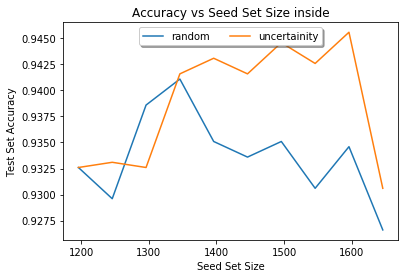

In [46]:
from matplotlib import pyplot as plt
fig = plt.figure()
ax = plt.subplot(111)
ax.plot(seed_set_size, random_accuracies, label='random')
ax.plot(seed_set_size, uncertainity_accuracies, label='uncertainity')
plt.title('Legend inside')
ax.legend(loc='upper center', shadow=True, ncol=2)
plt.xlabel('Seed Set Size')
plt.ylabel('Test Set Accuracy')
plt.title('Accuracy vs Seed Set Size inside')
plt.show()
plt.show()